## Alibi Overview Example

This notebook aims to demonstrate each of the explainers Alibi provides on the same model and dataset. Unfortunately, this isn't possible as white-box neural network methods exclude tree-based white-box methods. Hence we will train both a tensorflow and a random forest model on the same dataset and apply the full range of explainers to see what insights we can obtain. 

In [1]:
import requests
from io import BytesIO, StringIO
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os.path

import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

FROM_SCRATCH = False
TF_MODEL_FNAME = 'tf-clf-wine'
RFC_FNAME = 'rfc-wine'
ENC_FNAME = 'wine_encoder'
DEC_FNAME = 'wine_decoder'


## Preparing the data.

We're using the [wine-quality](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) dataset, a numeric tabular dataset containing features that refer to the chemical composition of wines and quality ratings. To make this a simple classification task, we bucket all wines with ratings greater than five as good, and the rest we label bad. As well as this we normalize all the features.

In [2]:
def fetch_wine_ds():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

    try:
        resp = requests.get(url, timeout=2)
        resp.raise_for_status()
    except requests.RequestException:
        logger.exception("Could not connect, URL may be out of service")
        raise
    string_io = StringIO(resp.content.decode('utf-8'))
    return pd.read_csv(string_io, sep=';')

In [3]:
df = fetch_wine_ds()

In [4]:
df['class'] = 'bad'
df.loc[(df['quality'] > 5), 'class'] = 'good'

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

df['good'] = 0
df['bad'] = 0
df.loc[df['class'] == 'good', 'good'] = 1
df.loc[df['class'] == 'bad', 'bad'] = 1

data = df[features].to_numpy()
labels = df[['class','good', 'bad']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_lab, y_test_lab = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

### Creating an Autoencoder

For some of the explainers, we need an autoencoder to check whether example instances are close to the training data distribution or not.

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import metrics, Input
from tensorflow import keras


ENCODING_DIM = 7
BATCH_SIZE = 64
EPOCHS = 100


class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
def make_ae():
    len_input_output = X_train.shape[-1]

    encoder = keras.Sequential()
    encoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(len_input_output, )))
    encoder.add(Dense(units=ENCODING_DIM, activation="relu"))

    decoder = keras.Sequential()
    decoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(ENCODING_DIM, )))
    decoder.add(Dense(units=len_input_output, activation="linear"))

    ae = AE(encoder=encoder, decoder=decoder)

    ae.compile(optimizer='adam', loss='mean_squared_error')
    history = ae.fit(
        scaler.transform(X_train), 
        scaler.transform(X_train), 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        verbose=False,)

    loss = history.history['loss']
    plt.plot(loss)
    plt.xlabel('Epoch')
    plt.ylabel('MSE-Loss')

    ae.encoder.save(f'{ENC_FNAME}.h5')
    ae.decoder.save(f'{DEC_FNAME}.h5')
    return ae

def load_ae_model():
    encoder = load_model(f'{ENC_FNAME}.h5')
    decoder = load_model(f'{DEC_FNAME}.h5')
    return AE(encoder=encoder, decoder=decoder)

# Random Forest Model

In order to get results for the tree shap model applied to the wine-quality data set we train a random forrest model.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def make_rfc():
    rfc = RandomForestClassifier(n_estimators=50)
    rfc.fit(scaler.transform(X_train), y_train_lab)
    y_pred = rfc.predict(scaler.transform(X_test))

    print('accuracy_score:', accuracy_score(y_pred, y_test_lab))
    print('f1_score:', f1_score(y_test_lab, y_pred, average=None))
    
    joblib.dump(rfc, f"{RFC_FNAME}.joblib")
    return rfc


def load_rfc_model():
    return joblib.load(f"{RFC_FNAME}.joblib")
    
# disp = ConfusionMatrixDisplay(confusion_matrix(y_test_lab, y_pred), display_labels=rfc.classes_)
# disp.plot()


# Tensorflow Model

Finally we also train a tensorflow model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers 

def make_tf_model():
    inputs = keras.Input(shape=X_train.shape[1])
    x = layers.Dense(6, activation="relu")(inputs)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(
        scaler.transform(X_train), 
        y_train,
        epochs=30, 
        verbose=False, 
        validation_data=(scaler.transform(X_test), y_test),
    )

    y_pred = model(scaler.transform(X_test)).numpy().argmax(axis=1)
    print('accuracy_score:', accuracy_score(y_pred, y_test.argmax(axis=1)))
    print('f1_score:', f1_score(y_pred, y_test.argmax(axis=1), average=None))

    model.save(f'{TF_MODEL_FNAME}.h5')
    
    return model

def load_tf_model():
    return load_model(f'{TF_MODEL_FNAME}.h5')


# disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_test.argmax(axis=1)))
# disp.plot()


# Load/Make models

In order to ensure stable results we save and load the same models each time unless they don't exist in which case we create new ones. If you want to generate new models on each run of the notebook then set `FROM_SCRATCH=True`

In [8]:
from tensorflow.keras.models import Model, load_model

if FROM_SCRATCH or not os.path.isfile(f'{TF_MODEL_FNAME}.h5'):
    model = make_tf_model()
    rfc = make_rfc()
    ae = make_ae()
else:
    rfc = load_rfc_model()
    model = load_tf_model() 
    ae = load_ae_model()

# Select Instance of good wine 

We partition the dataset into good and bad portions and select an instance of interest. I've chosen it to be a good quality wine. 

Note that 
- bad => class 1 
- good => class 0.

In [9]:
bad_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 1])
good_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 0])
# x = X_train[(model(X_train).numpy()[:, 0] > 0.7) & (model(X_train).numpy()[:, 0] < 0.9)][0][None]

x = np.array([[9.2, 0.36, 0.34, 1.6, 0.062, 5., 12., 0.99667, 3.2, 0.67, 10.5]])
x_res = model.predict(x)[0]
print('class probs: ', x_res)
assert x_res.argmax() == 0, "x_res.argmax() != 0, model should classisfy x as 0 but non-determinism of model training might mean it doesn't. You can choose a new x as you wish"
print('result is class ', x_res.argmax())

class probs:  [0.7731959  0.22680412]
result is class  0



# Util functions for visualizing and comparing instance differences

In [10]:
def plot_cf_and_feature_dist(x, cf, feature='total sulfur dioxide'):
    """
    Create a kde plot of feature distribution and plot counter factual and instance feature values.
    """
    ind = features.index(feature)
    ax = sns.kdeplot(bad_wines[:, ind], bw_method=0.5, c='r')
    sns.kdeplot(good_wines[:, ind], bw_method=0.5, c='b')
    plt.axvline(x=x[:, ind], c='b', alpha=0.4)
    plt.axvline(x=cf[:, ind], c='r', alpha=0.4) 
    plt.xticks([x[0, ind], cf[0, ind]], ['x', 'c'])
    plt.ylabel('Probability')
    plt.xlabel(' '.join([word.capitalize() for word in feature.split(' ')]))
    plt.show()


In [11]:
def compare_instances(x, cf):
    """
    Show the difference in values between two instances.
    """
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v1 - v2, 7):^5}')


In [12]:
def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

## Integrated Gradients

We illustrate the apllication of integrated to the instance of interest

(<AxesSubplot:xlabel='Feature effects for class "good"'>,
 <Figure size 720x360 with 1 Axes>)

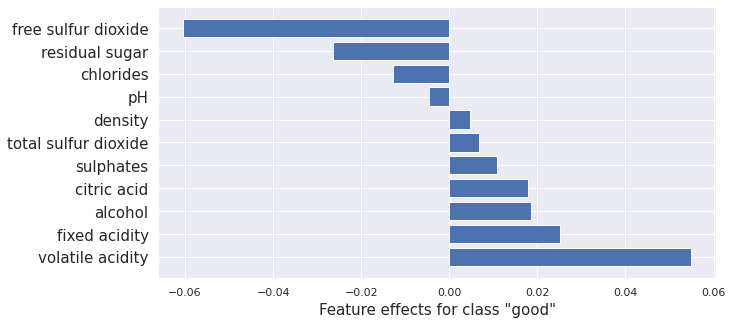

In [13]:
from alibi.explainers import IntegratedGradients

ig = IntegratedGradients(model,
                         layer=None,
                         method="gausslegendre",
                         n_steps=50,
                         internal_batch_size=100)

result = ig.explain(scaler.transform(x), target=0)

plot_importance(result.data['attributions'][0], features, '"good"')


## Kernel SHAP

Example of Kernel SHAP method applied to the Tensorflow model

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Feature effects for class 0'>,
 <Figure size 720x360 with 1 Axes>)

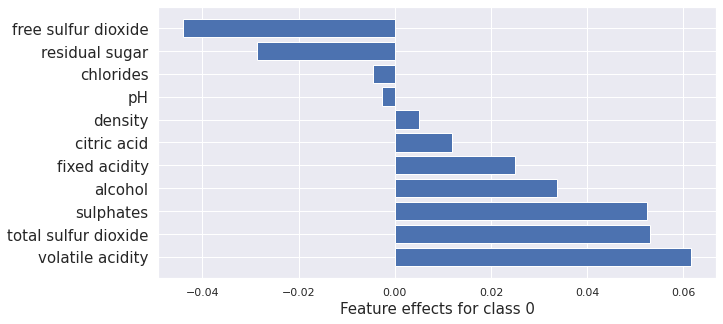

In [15]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[0], features, 0)


Here we apply Kernel SHAP to the Tree-based model in order to compare to the tree-based methods we run later

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

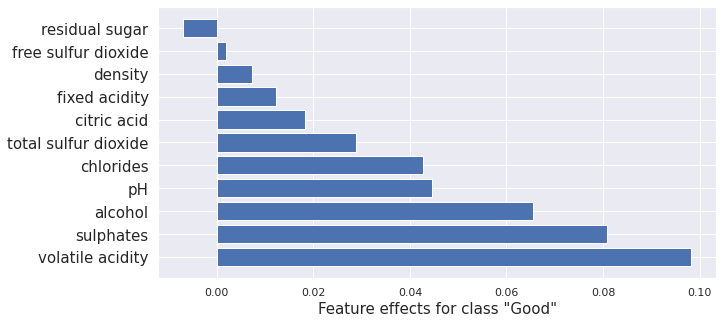

In [16]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: rfc.predict_proba(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[1], features, '"Good"')

## Interventional treeSHAP

Interventional tree SHAP applied to the random forest. Comparison with the kernel SHAP results above show very similar outcomes.

(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

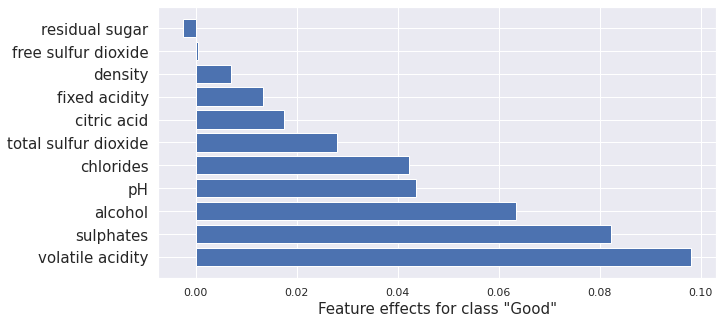

In [17]:
from alibi.explainers import TreeShap

tree_explainer_interventional = TreeShap(rfc, model_output='raw', task='classification')
tree_explainer_interventional.fit(scaler.transform(X_train[0:100]))
result = tree_explainer_interventional.explain(scaler.transform(x))

plot_importance(result.shap_values[1], features, '"Good"')


## Path Dependent treeSHAP

Path Dependent tree SHAP applied to random forest. Again very similar results to kernel SHAP and Interventional tree SHAP as expected.

(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

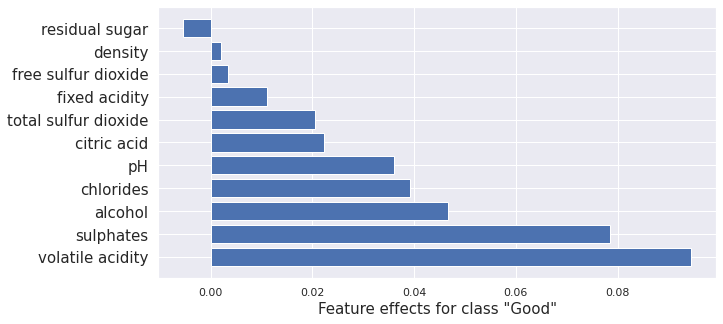

In [19]:
path_dependent_explainer = TreeShap(rfc, model_output='raw', task='classification')
path_dependent_explainer.fit()
result = path_dependent_explainer.explain(scaler.transform(x))

plot_importance(result.shap_values[1], features, '"Good"')


## Note:

There is some difference between the kernel SHAP and integrated gradient applied to the tensorflow model and the SHAP methods applied to the random forest. This is to be exected due to the combination of different methods and different models. They are reasonably similar overall however. notably the ordering is nearly the same.

## Anchors

Here we apply Anchors to the tensor flow model

In [19]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = AnchorTabular(predict_fn, features)
explainer.fit(X_train, disc_perc=(25, 50, 75))
result = explainer.explain(x, threshold=0.95)

In [20]:
print('Anchor =', result.data['anchor'])
print('Precision = ', result.data['precision'])
print('Coverage = ', result.data['coverage'])

Anchor = ['alcohol > 10.10', 'volatile acidity <= 0.39']
Precision =  0.9629629629629629
Coverage =  0.16263552960800667


## ALE 

The following is the ALE plot for the alcohol feature

array([[<AxesSubplot:xlabel='alcohol', ylabel='ALE'>]], dtype=object)

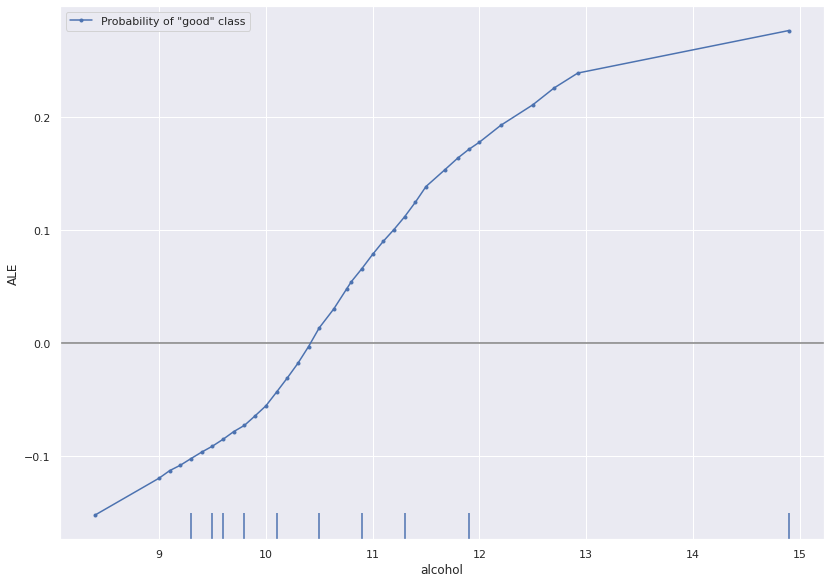

In [22]:
from alibi.explainers import ALE
from alibi.explainers import plot_ale

predict_fn = lambda x: model(scaler.transform(x)).numpy()[:, 0]
ale = ALE(predict_fn, feature_names=features)
exp = ale.explain(X_train)
plot_ale(exp, features=['alcohol'], line_kw={'label': 'Probability of "good" class'})

# Counterfactuals

Next we apply each of the counterfactual methods, counterfactuals with reinforcement learning, counterfactual instances, counterfacutals with prototypes and contrastive explanation methods. We also plot the kernel SHAP values to show how the counterfactual method changes hte

## Counter Factuals with Reinforcement Learning

In [23]:
from alibi.explainers import CounterfactualRL 

predict_fn = lambda x: model(x)

cfrl_explainer = CounterfactualRL(predictor=predict_fn,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=7,
                             coeff_sparsity=0.5,
                             coeff_consistency=0.5,
                             train_steps=10000,
                             batch_size=100,
                             backend="tensorflow")

In [24]:
cfrl_explainer.fit(X=scaler.transform(X_train))

100%|██████████| 10000/10000 [02:11<00:00, 76.16it/s]


CounterfactualRL(meta={
  'name': 'CounterfactualRL',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'act_noise': 0.1,
              'act_low': -1.0,
              'act_high': 1.0,
              'replay_buffer_size': 1000,
              'batch_size': 100,
              'num_workers': 4,
              'shuffle': True,
              'exploration_steps': 100,
              'update_every': 1,
              'update_after': 10,
              'train_steps': 10000,
              'backend': 'tensorflow',
              'encoder_preprocessor': 'identity_function',
              'decoder_inv_preprocessor': 'identity_function',
              'reward_func': 'get_classification_reward',
              'postprocessing_funcs': [],
              'conditional_func': 'generate_empty_condition',
              'callbacks': [],
              'actor': "<class 'alibi.models.tensorflow.actor_critic.Actor'>",
              'critic': "<class 'alibi.models.tensorflow.actor_critic.C

100%|██████████| 1/1 [00:00<00:00, 148.20it/s]


fixed acidity             instance:   8.965    counter factual:    9.2     difference: -0.2350657
volatile acidity          instance:   0.349    counter factual:    0.36    difference: -0.0108247
citric acid               instance:   0.242    counter factual:    0.34    difference: -0.0977357
residual sugar            instance:   2.194    counter factual:    1.6     difference: 0.5943643
chlorides                 instance:   0.059    counter factual:   0.062    difference: -0.0031443
free sulfur dioxide       instance:   6.331    counter factual:    5.0     difference: 1.3312454
total sulfur dioxide      instance:   14.989   counter factual:    12.0    difference: 2.9894428
density                   instance:   0.997    counter factual:   0.997    difference: 0.0003435
pH                        instance:   3.188    counter factual:    3.2     difference: -0.0118126
sulphates                 instance:   0.598    counter factual:    0.67    difference: -0.0718592
alcohol                 

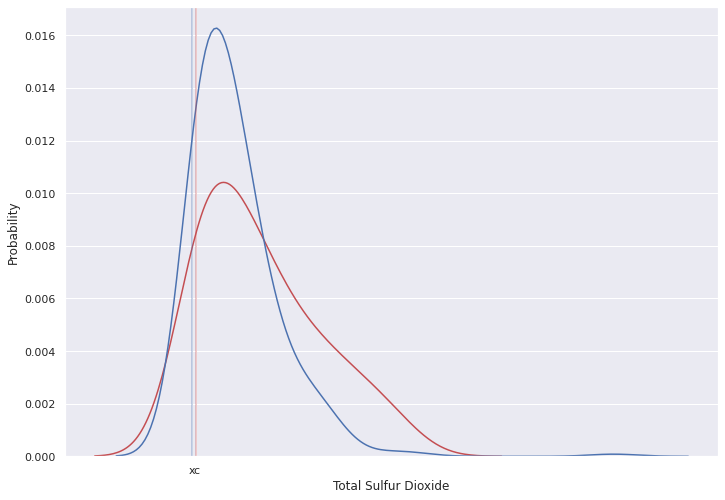

In [25]:
result_cfrl = cfrl_explainer.explain(X=scaler.transform(x), Y_t=np.array([1]))
cfrl = scaler.inverse_transform(result_cfrl.data['cf']['X'])
compare_instances(cfrl, x)
plot_cf_and_feature_dist(x, cfrl, feature='total sulfur dioxide')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.16304969346684278
-0.09016794144836963


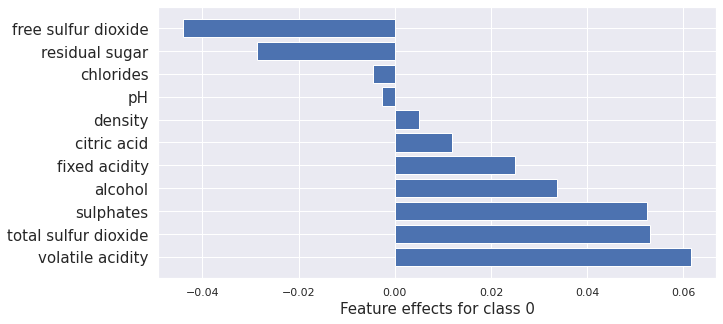

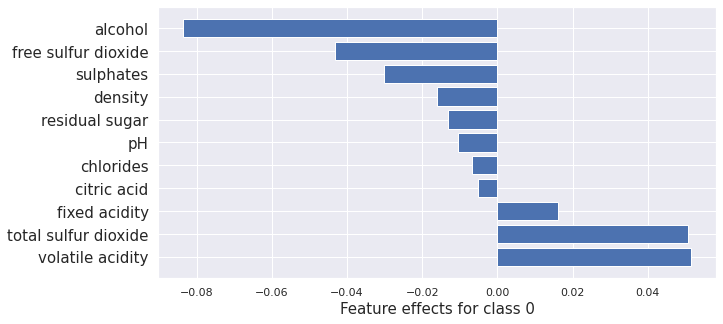

In [26]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cfrl = explainer.explain(cfrl)

plot_importance(result_x.shap_values[0], features, 0)
print(result_x.shap_values[0].sum())
plot_importance(result_cfrl.shap_values[0], features, 0)
print(result_cfrl.shap_values[0].sum())

## Set up tfv1

In [27]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [28]:
from tensorflow.keras.models import Model, load_model
model = load_tf_model() 
ae = load_ae_model()

## Counterfactual Instances

In [29]:
from alibi.explainers import Counterfactual

explainer = Counterfactual(
    model, shape=(1,) + X_train.shape[1:], target_proba=0.51, tol=0.01, target_class='other', 
    max_iter=1000, lam_init=1e-1, max_lam_steps=10, learning_rate_init=0.1,
    feature_range=(scaler.transform(X_train).min(), scaler.transform(X_train).max())
)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


fixed acidity             instance:    9.2     counter factual:    9.23    difference: -0.030319
volatile acidity          instance:    0.36    counter factual:    0.36    difference: 0.0004017
citric acid               instance:    0.34    counter factual:   0.334    difference: 0.0064294
residual sugar            instance:    1.6     counter factual:   1.582    difference: 0.0179322
chlorides                 instance:   0.062    counter factual:   0.061    difference: 0.0011683
free sulfur dioxide       instance:    5.0     counter factual:   4.955    difference: 0.0449123
total sulfur dioxide      instance:    12.0    counter factual:   11.324   difference: 0.6759205
density                   instance:   0.997    counter factual:   0.997    difference: -5.08e-05
pH                        instance:    3.2     counter factual:   3.199    difference: 0.0012383
sulphates                 instance:    0.67    counter factual:    0.64    difference: 0.0297857
alcohol                   inst

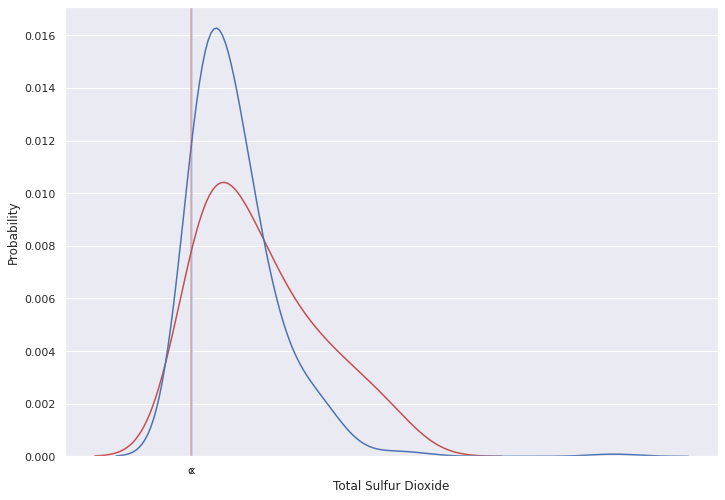

In [30]:
result_cf = explainer.explain(scaler.transform(x))
cf = result_cf.data['cf']['X']
cf = scaler.inverse_transform(cf)
compare_instances(x, cf)
plot_cf_and_feature_dist(x, cf, feature='total sulfur dioxide')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Feature effects for class 0'>,
 <Figure size 720x360 with 1 Axes>)

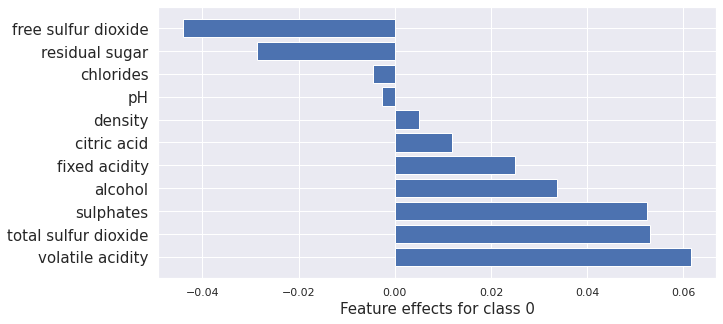

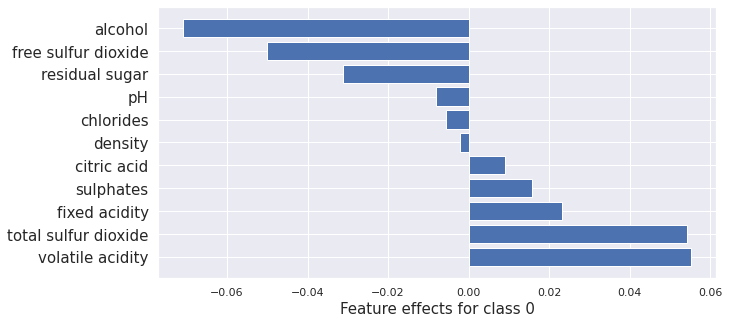

In [31]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cf = explainer.explain(cf)

plot_importance(result_x.shap_values[0], features, 0)
# print(result_x.shap_values[0].sum())
plot_importance(result_cf.shap_values[0], features, 0)
# print(result_cf.shap_values[0].sum())

## Contrastive Explanations Method

In [32]:
from alibi.explainers import CEM
shape = (1,) + X_train.shape[1:]

feature_range = (scaler.transform(X_train).min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 scaler.transform(X_train).max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
cem = CEM(model, mode='PN', shape=(1,) + X_train.shape[1:], kappa=0.2, beta=0.1, 
          feature_range=feature_range, max_iterations=1000, c_init=10, c_steps=10,
          learning_rate_init=1e-2, clip=(-1000, 1000), ae_model=ae)

cem.fit(scaler.transform(X_train), no_info_type='median')
result_cem = cem.explain(scaler.transform(x), verbose=False)

fixed acidity             instance:    9.2     counter factual:    9.2     difference: 2e-07
volatile acidity          instance:    0.36    counter factual:    0.36    difference: -0.0 
citric acid               instance:    0.34    counter factual:    0.34    difference: -0.0 
residual sugar            instance:    1.6     counter factual:    1.6     difference: 1e-07
chlorides                 instance:   0.062    counter factual:   0.062    difference:  0.0 
free sulfur dioxide       instance:    5.0     counter factual:    5.0     difference:  0.0 
total sulfur dioxide      instance:    12.0    counter factual:    12.0    difference: 1.9e-06
density                   instance:   0.997    counter factual:   0.997    difference: -0.0 
pH                        instance:    3.2     counter factual:    3.2     difference: -0.0 
sulphates                 instance:    0.67    counter factual:    0.57    difference: 0.100164
alcohol                   instance:    10.5    counter factual:  

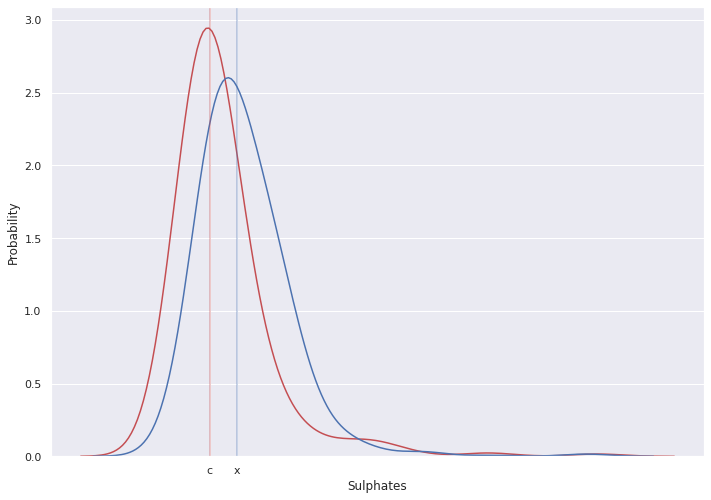

In [33]:
cem_cf = result_cem.data['PN']
cem_cf = scaler.inverse_transform(cem_cf)
compare_instances(x, cem_cf)
plot_cf_and_feature_dist(x, cem_cf, feature='sulphates')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.16304971136152735
-0.12879829250276098


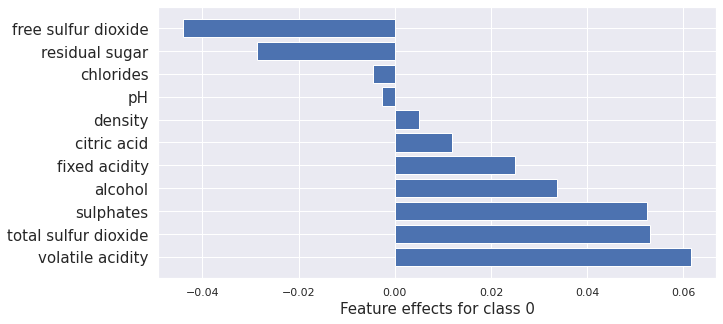

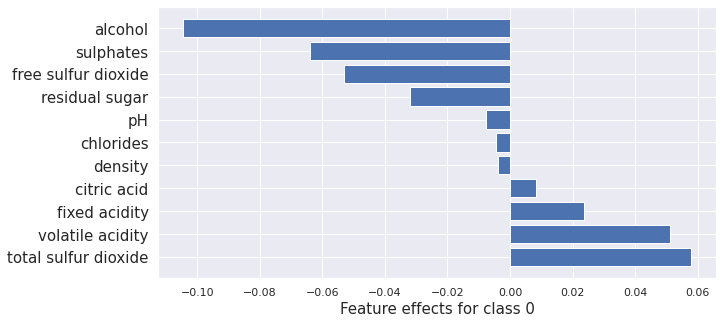

In [34]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cem_cf = explainer.explain(cem_cf)

plot_importance(result_x.shap_values[0], features, 0)
print(result_x.shap_values[0].sum())
plot_importance(result_cem_cf.shap_values[0], features, 0)
print(result_cem_cf.shap_values[0].sum())

## Counterfactual With Prototypes

In [35]:
from alibi.explainers import CounterfactualProto

explainer = CounterfactualProto(
    model,
    shape=shape,
    ae_model=ae,
    enc_model=ae.encoder,
    max_iterations=500,
    feature_range=feature_range,
    c_init=1., 
    c_steps=4,
    eps=(1e-2, 1e-2), 
    update_num_grad=100
)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [36]:
explainer.fit(scaler.transform(X_train))
result_proto = explainer.explain(scaler.transform(x), Y=None, target_class=None, k=20, k_type='mean',
                                 threshold=0., verbose=False, print_every=100, log_every=100)

fixed acidity             instance:    9.2     counter factual:    9.2     difference: 2e-07
volatile acidity          instance:    0.36    counter factual:    0.36    difference: -0.0 
citric acid               instance:    0.34    counter factual:    0.34    difference: -0.0 
residual sugar            instance:    1.6     counter factual:    1.6     difference: 1e-07
chlorides                 instance:   0.062    counter factual:   0.062    difference:  0.0 
free sulfur dioxide       instance:    5.0     counter factual:    5.0     difference:  0.0 
total sulfur dioxide      instance:    12.0    counter factual:    12.0    difference: 1.9e-06
density                   instance:   0.997    counter factual:   0.997    difference: -0.0 
pH                        instance:    3.2     counter factual:    3.2     difference: -0.0 
sulphates                 instance:    0.67    counter factual:   0.607    difference: 0.0627938
alcohol                   instance:    10.5    counter factual: 

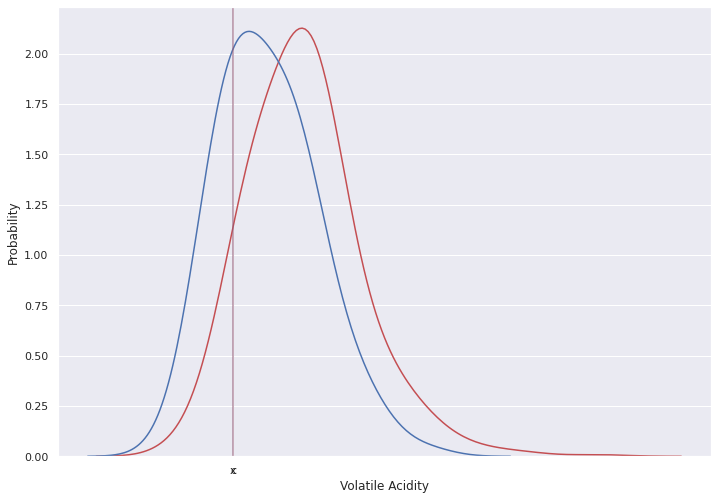

In [37]:
proto_cf = result_proto.data['cf']['X']
proto_cf = scaler.inverse_transform(proto_cf)
compare_instances(x, proto_cf)
plot_cf_and_feature_dist(x, proto_cf, feature='volatile acidity')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.16304971136152735
-0.12879829250276098


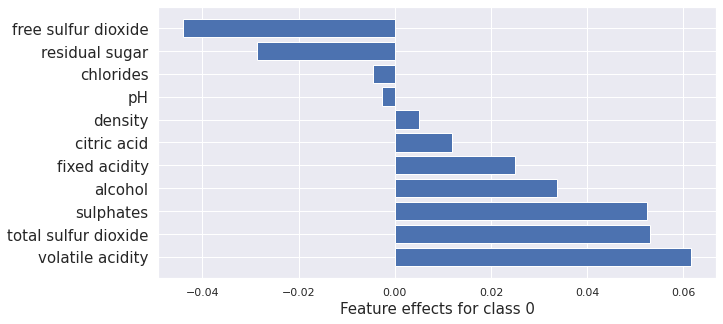

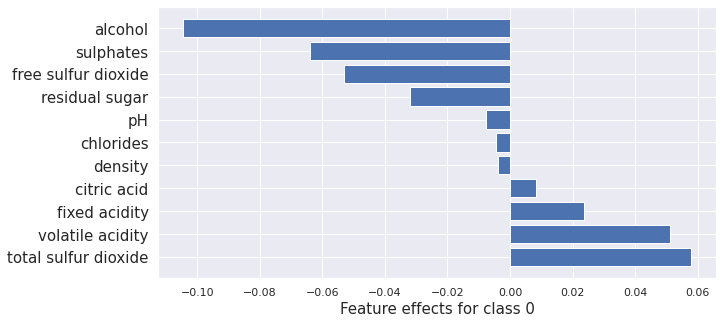

In [38]:
import shap
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_proto_cf = explainer.explain(cem_cf)

plot_importance(result_x.shap_values[0], features, 0)
print(result_x.shap_values[0].sum())
plot_importance(result_proto_cf.shap_values[0], features, 0)
print(result_proto_cf.shap_values[0].sum())